This code will follow this order:
1. Create initial population
2. Rank individuals by its fitness
3. Create mating pool
4. Crossover
5. Mutate
6. Repeat

Based on the code by Eric Stoltz:
https://towardsdatascience.com/evolution-of-a-salesman-a-complete-genetic-algorithm-tutorial-for-python-6fe5d2b3ca35

In [165]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt
from os import path

## Create necessary classes and functions

Create class to handle "cities"

In [166]:
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

Create a fitness function

In [167]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness = 0.0
    
    def routeDistance(self):
        if self.distance == 0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                # z.B. Route besteht aus 10 Städten, also stoppt Schleife bei i=9
                if i + 1 < len(self.route): 
                    toCity = self.route[i + 1]
                else: # Rückkehr zum Ausgangspunkt
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

# 1. Create our initial population
Route generator

In [168]:
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route

def initialPopulation(popSize, cityList):
    population = []
    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

# 2. Rank routes by its fitness
Rank individuals

In [169]:
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

# 3. Create the mating pool
Create a selection function to list parent routes - selectionResults will output only RouteIDs, not the routes themselves

In [170]:
def selection(popRanked, eliteSize): # Was für ein Datentyp ist popRanked?
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize): # Elite: Die besten Individuen kommen in die nächste Generation 
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize): # Roulette-Auswahl der Kindergeneration
        pick = 100*random.random() # zufällige Zahl 0-100; Roulette-Rad
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]: # z.B. pick=30 und cum_sum=50, dann wird Individuum in popRanked hinzugefügt
                selectionResults.append(popRanked[i][0])
                break # Gehe aus der for-Schleife raus und pick eine neue zufällige Zahl
    return selectionResults

Create mating pool from the RouteIDs from selectionResults

In [171]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i] #
        matingpool.append(population[index])
    return matingpool

# 4. Breed (Crossover)
Create a crossover function for two parents to create one child

With our mating pool created, we can create the next generation in a process called crossover (aka “breeding”). If our individuals were strings of 0s and 1s and our two rules didn’t apply (e.g., imagine we were deciding whether or not to include a stock in a portfolio), we could simply pick a crossover point and splice the two strings together to produce an offspring.

However, the TSP is unique in that we need to include all locations exactly one time. To abide by this rule, we can use a special breeding function called ordered crossover. In ordered crossover, we randomly select a subset of the first parent string (see line 12 in breed function below) and then fill the remainder of the route with the genes from the second parent in the order in which they appear, without duplicating any genes in the selected subset from the first parent (see line 15 in breed function below).

                                    Parents
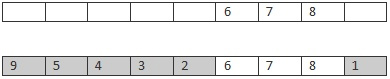

                                    Offspring
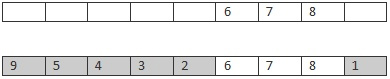

In [172]:
def breed(parent1, parent2):
    child = []
    childP1 = [] # Steht P für parent oder part?
    childP2 = [] # Was ist die Länge von childP1 und P2? Wie viel Kinder pro Elternpaar?
    
    geneA = int(random.random() * len(parent1)) # z.B. n=15 Städte, dann random(0.5)*15=7.5 --> int=8
    geneB = int(random.random() * len(parent1)) # z.B randon(0.1)*15=1.5 --> int=2
    
    startGene = min(geneA, geneB) # 2
    endGene = max(geneA, geneB) # 8

    for i in range(startGene, endGene): # von 2 bis 8
        childP1.append(parent1[i]) # Füge dem Kind von Stelle 2 bis 8 die Städte-Reihenfolge aus Parent1
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

In [173]:
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize # z.B. 100 Indiviuen, 20 Eliten
    pool = random.sample(matingpool, len(matingpool)) # 100 Stichproben aus dem Matingpool

    for i in range(0,eliteSize): # Die 20 besten Individuen kommen in die Kinder-Generation
        children.append(matingpool[i])
    
    for i in range(0, length): # von 0 bis 80
        child = breed(pool[i], pool[len(matingpool)-i-1]) # parent1[0] und parent2[80-0-1] 
        children.append(child)
    return children

# 5. Mutate

In [174]:
def mutate(individual, mutationRate):
    for swapped in range(len(individual)): # Ein Individuum ist 15 Städte lang
        if(random.random() < mutationRate): # Wenn random kleiner als 0.05, dann swap
            swapWith = int(random.random() * len(individual)) # z.B. 0.33*15=5
            
            city1 = individual[swapped] # swapped von 0 bis 15, hier 0
            city2 = individual[swapWith] # swappen mit 5
            
            individual[swapped] = city2 # city2 ist jetzt Stadt 0
            individual[swapWith] = city1 # city1 ist jetzt Stadt 5 im Individuum X
    return individual

In [175]:
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)): # Population ist 100 Individuen groß
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

# 6. Repeat 
# Plot route, distance and progress together

In [176]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

In [323]:
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1])) 
    # rankRoutes(pop) gibt eine Liste mit den 100 Individuen mit Indexnummer und Fitnesswert aus
    outpath = "C:/Users/Kevin/Desktop/Masterarbeit/Python Code/plots"
    fig, ax = plt.subplots()
    ax.set_xlim(0,200)
    ax.set_ylim(0,200)
    
    # Plot best route for each generation 
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        #print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
        bestRouteIndex = rankRoutes(pop)[0][0]
        bestRoute = pop[bestRouteIndex]
        
        # Create a DataFrame to plot the route 
        xlist = []
        ylist = []
        for j in range(len(bestRoute)):
            xlist.append(bestRoute[j].x) # We use .x and .y because the object is of class City 
            ylist.append(bestRoute[j].y)
        df = pd.DataFrame()
        df["x"] = xlist
        df["y"] = ylist
        
        # Plot the route
        plt.title("Distance = " + str(round(1 / rankRoutes(pop)[0][1])))
        plt.scatter(x=df["x"], y=df["y"])
        plt.arrow(xlist[-1], ylist[-1], (xlist[0] - xlist[-1]), (ylist[0] - ylist[-1]))
        for k in range(0, len(xlist)-1):
            plt.arrow(xlist[k], ylist[k], (xlist[k+1] - xlist[k]), (ylist[k+1] - ylist[k]))
        
        fig.savefig(path.join(outpath,"generation{0}.png".format(i)))
        fig.clear()
        
        # Last plot to display result
        plt.title("Distance = " + str(round(1 / rankRoutes(pop)[0][1])))
        plt.scatter(x=df["x"], y=df["y"])
        plt.arrow(xlist[-1], ylist[-1], (xlist[0] - xlist[-1]), (ylist[0] - ylist[-1]))
        for k in range(0, len(xlist)-1):
            plt.arrow(xlist[k], ylist[k], (xlist[k+1] - xlist[k]), (ylist[k+1] - ylist[k]))
    return print("bestRoute:",bestRoute)

In [324]:
cityList = []
random.seed(1)
for i in range(0,25):
    cityList.append(City(x=int(random.random() * 200), y=int(random.random() * 200)))
print(cityList)

[(26,169), (152,51), (99,89), (130,157), (18,5), (167,86), (152,0), (89,144), (45,189), (180,6), (5,108), (187,76), (43,84), (5,44), (87,99), (46,46), (43,91), (57,4), (167,111), (128,37), (198,171), (24,66), (144,142), (187,84), (166,134)]


Initial distance: 2329.6554890196217
bestRoute: [(166,134), (144,142), (130,157), (198,171), (187,84), (187,76), (167,86), (99,89), (87,99), (89,144), (45,189), (26,169), (5,108), (43,91), (43,84), (46,46), (24,66), (5,44), (18,5), (57,4), (128,37), (152,0), (180,6), (152,51), (167,111)]


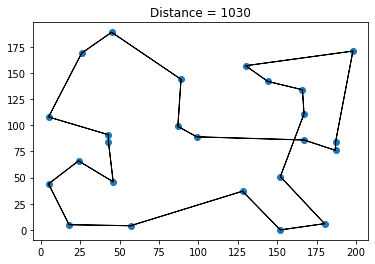

In [325]:
geneticAlgorithm(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)

In [ ]:
def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
    
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()

In [ ]:
geneticAlgorithmPlot(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)